In [ ]:
# 这篇文章核心的一点发现是：通过定义一个enrichment score，把乳腺癌分成两类。然后这两类的预后不同。
# 相当于他是事先知道immnue和tumor的相互作用和预后有关。
# 我们现在相当于既能够发现且证明他的结论，也能发现所有其他和预后相关的相互作用。包括一阶和二阶。
# 而且我们还可以用所有相互作用的信息，来预测新的病人的预后

In [ ]:
# 回归时，需要做argmentation，就是每个图分多个小块

# imports

In [1]:
import h5py
import scanpy as sc
import seaborn as sns
import collections
import scipy.sparse as sp_sparse
import tables
import numpy as np
import matplotlib.pyplot as plt
import scanorama
import pandas as pd
import anndata as ad
from scipy.spatial.distance import *
import pyfpgrowth
import pickle
import networkx as nx
# from ged4py.algorithm import graph_edit_dist
import umap
from scipy.stats import *
import palettable
import cv2

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# functions

## common

# specific

In [5]:
from PIL import Image
import numpy as np

def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)



def get_MIBI_adata(patient_no):
# patient_no = 16
    cur_tif_file = tiff_path+'TA459_multipleCores2_Run-4_Point{0}.tiff'.format(patient_no)
    tiff = read_tiff(cur_tif_file)

    seg_file = seg_path+'TA459_multipleCores2_Run-4_Point{0}_Overlay.png'.format(patient_no)
    img = cv2.imread(seg_file)

    img_0 = img[:,:,0]

    import skimage
    from skimage.viewer.viewers import ImageViewer
    mask = img_0 > 200


    labeled_image = skimage.measure.label(mask, connectivity=2, return_num=True)[0]


    plt.imshow(img)
    plt.title('original')
    plt.show()
    plt.imshow(mask)
    plt.title('binary mask')
    plt.show()
    plt.imshow(labeled_image)
    plt.title('labeled image')
    plt.show()


    var_list = ['Au','Background','Beta catenin','Ca','CD11b','CD11c','CD138','CD16',
               'CD20','CD209','CD3','CD31','CD4','CD45','CD45RO','CD56','CD63','CD68',
               'CD8','dsDNA','EGFR','Fe','FoxP3','H3K27Me3','H3K9ac','HLA-DR','HLA_Class_1',
               'IDO','Keratin17','Keratin6','Ki67','Lag3','MPO','Na','P','p53','Pan-Keratin',
               'PD-L1','PD1','phospho-S6','Si','SMA','Ta','Vimentin']


    cell_num = labeled_image.max()
    cell_pixel_dict = {}
    cell_pos_dict = {}
    # key：cellidx（1开始）；value：numpy matrix，num_pixels*num_vars
    for i in range(labeled_image.shape[0]):
        for j in range(labeled_image.shape[1]):
            cur_label = labeled_image[i,j]
            cur_pixel_profile = tiff[:,i,j]
            if cur_label==0:
                continue
            if cur_label not in cell_pixel_dict:
                cell_pixel_dict[cur_label] = [cur_pixel_profile]
                cell_pos_dict[cur_label] = [np.array([i,j])]
            else:
                cell_pixel_dict[cur_label].append(cur_pixel_profile)
                cell_pos_dict[cur_label].append(np.array([i,j]))

    for cell_idx in cell_pixel_dict.keys():
        cell_pixel_dict[cell_idx] = np.vstack(cell_pixel_dict[cell_idx])
        cell_pos_dict[cell_idx] = np.vstack(cell_pos_dict[cell_idx])


    X_mat = []
    spatial_mat = []
    cell_size_mat = []
    for cell_idx in cell_pixel_dict:
        cur_X = np.mean(cell_pixel_dict[cell_idx],axis=0)
        cur_spatial = np.mean(cell_pos_dict[cell_idx],axis=0)
        cur_cell_size = cell_pixel_dict[cell_idx].shape[0]
        X_mat.append(cur_X)
        spatial_mat.append(cur_spatial)
        cell_size_mat.append(cur_cell_size)
    X_mat = np.vstack(X_mat)
    spatial_mat = np.vstack(spatial_mat)
    cell_size_mat = np.array(cell_size_mat)

    X_mat = np.arcsinh(X_mat)

    adata = ad.AnnData(X = X_mat,var=pd.DataFrame(index=var_list))

    adata.obsm['spatial'] = spatial_mat
    adata.obs['cell_size'] = cell_size_mat


    sc.pl.embedding(adata,basis='spatial',
                    color=['cell_size','SMA','Beta catenin','CD11b'],
                   ncols=2,
                   s=50)
    return adata,labeled_image,tiff,var_list

# settings

In [47]:
%matplotlib inline

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

tiff_path = '/home/yzy/PUBDT/st/MIBI/BC/tiff/'
seg_path = '/home/yzy/PUBDT/st/MIBI/BC/segmentation_mask/'
h5ad_path = '/home/yzy/PUBDT/st/MIBI/BC/h5ad/'

var_list = ['Au','Background','Beta catenin','Ca','CD11b','CD11c','CD138','CD16',
           'CD20','CD209','CD3','CD31','CD4','CD45','CD45RO','CD56','CD63','CD68',
           'CD8','dsDNA','EGFR','Fe','FoxP3','H3K27Me3','H3K9ac','HLA-DR','HLA_Class_1',
           'IDO','Keratin17','Keratin6','Ki67','Lag3','MPO','Na','P','p53','Pan-Keratin',
           'PD-L1','PD1','phospho-S6','Si','SMA','Ta','Vimentin']

protein_list = ['Beta catenin','CD11b','CD11c','CD138','CD16',
           'CD20','CD209','CD3','CD31','CD4','CD45','CD45RO','CD56','CD63','CD68',
           'CD8','dsDNA','EGFR','FoxP3','H3K27Me3','H3K9ac','HLA-DR','HLA_Class_1',
           'IDO','Keratin17','Keratin6','Ki67','Lag3','MPO','p53','Pan-Keratin',
           'PD-L1','PD1','phospho-S6','SMA','Vimentin']
sns.set_style('white')

# processing

## breast cancer MIBI resize

In [122]:
tiff_file = 'TA459_multipleCores2_Run-4_Point1.tiff'
tiff = read_tiff(tiff_path+tiff_file)
write_path = '/home/yzy/bioSIMS/data/raw/test_MIBI/'

top_rows = """# Source Filename: liver-fiber-20191204-3_1
# Source Interval: 521.46 u (ID: 230)
# Field of View: 3.999996e+002 x 3.999996e+002 um
# Scans 0 to 144
# Not using shift correction
# Not using poisson correction
# Shots per pixel: 580
# Image Size: 256 x 256 pixels

"""

In [161]:
x_range=(0,256)
y_range=(0,256)
var_list = np.arange(len(var_list))
to_write_matrix = tiff[:,x_range[0]:x_range[1],y_range[0]:y_range[1]]
for v in range(len(var_list)):
    cur_file = '{0}{1}.00.txt'.format(write_path,var_list[v])
    with open(cur_file,'w') as f:
        f.write(top_rows)
        for i in range(to_write_matrix.shape[1]):
            for j in range(to_write_matrix.shape[2]):
                cur_row = '{0} {1} '.format(i,j)
                cur_row += '{:.6e}\n'.format(to_write_matrix[v,i,j])
                
#                 print(cur_row)
                f.write(cur_row)

In [121]:
var_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

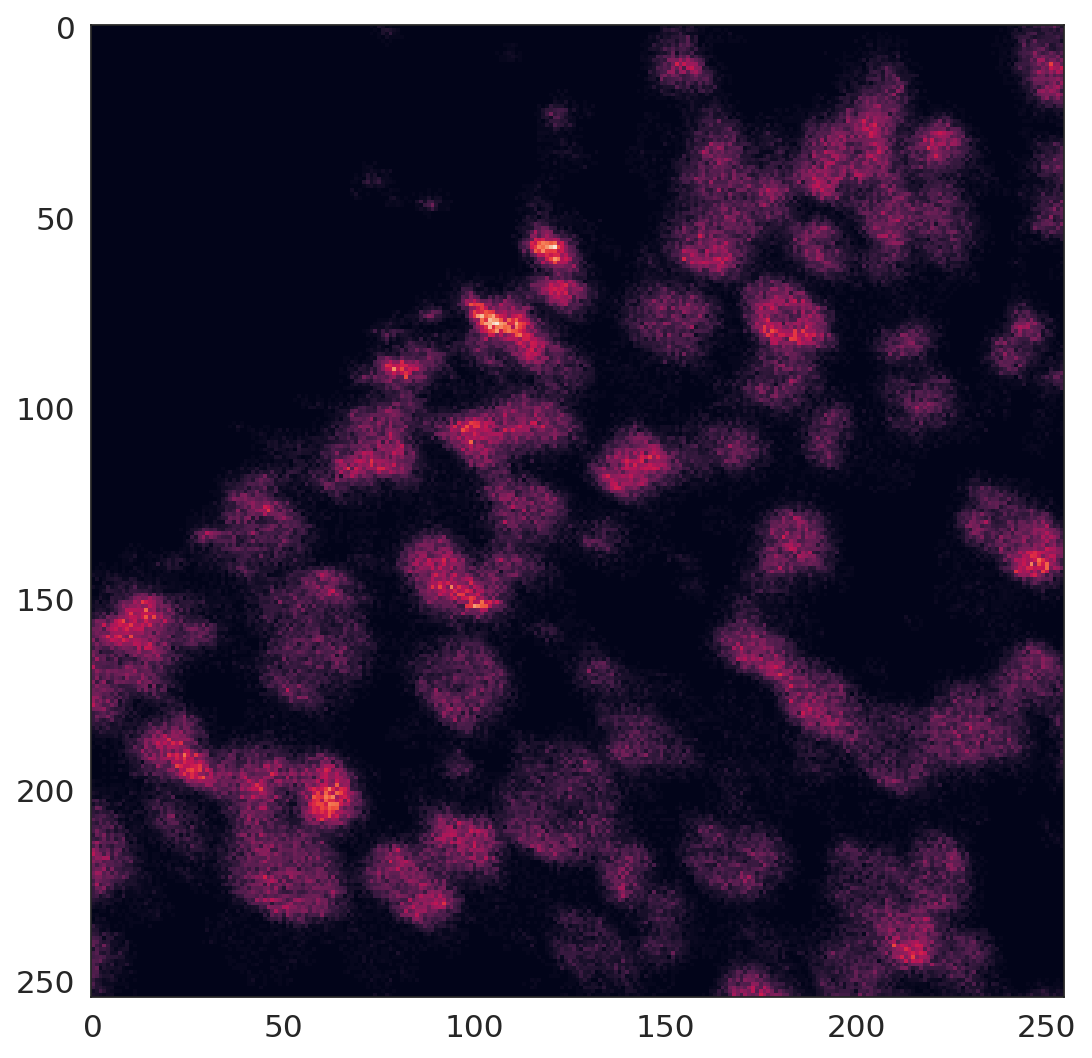

In [76]:
var_idx = np.where(np.array(var_list)=='dsDNA')[0][0]
idx_img = to_write_matrix[var_idx,:]
# idx_img = np.log(idx_img+1)
# idx_img = np.log(idx_img+1)

plt.imshow(idx_img)

# read test_samples_20

In [166]:
import scipy.io as sio
MIBI_file = '/home/yzy/bioSIMS/data/process/test_MIBI_None/preprocess/test_samples_20.mat'
SIMS_file = '/home/yzy/bioSIMS/data/process/cl_10a_None_auto/preprocess/test_samples_20.mat'
matters_file = '/home/yzy/bioSIMS/data/process/test_MIBI_None/preprocess/matters_candidate.pkl'
MIBI_nuclei_top = sio.loadmat(MIBI_file)['test_samples']
SIMS_nuclei_top = sio.loadmat(SIMS_file)['test_samples']
with open(matters_file, 'rb') as handle:
    matters_candidates = pickle.load(handle)



2

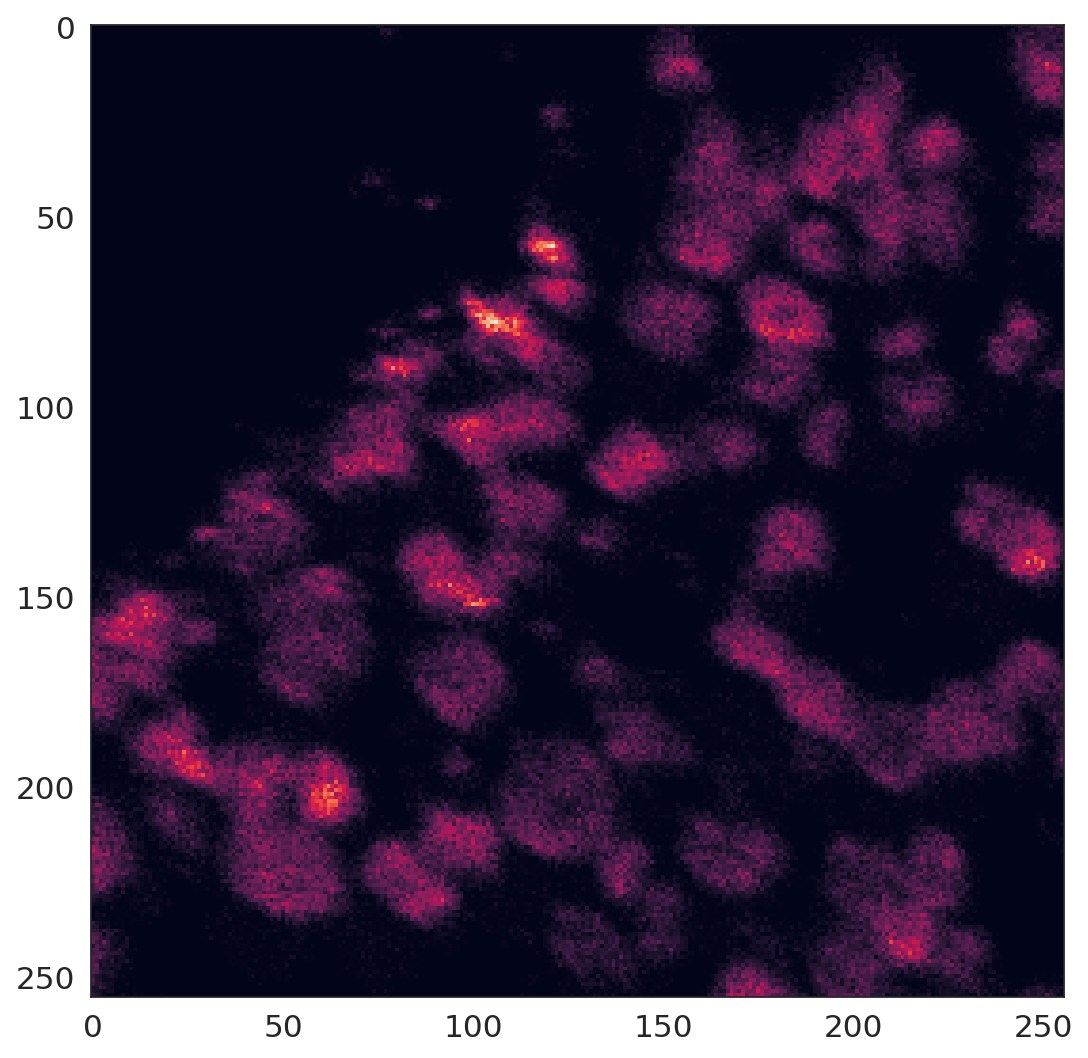

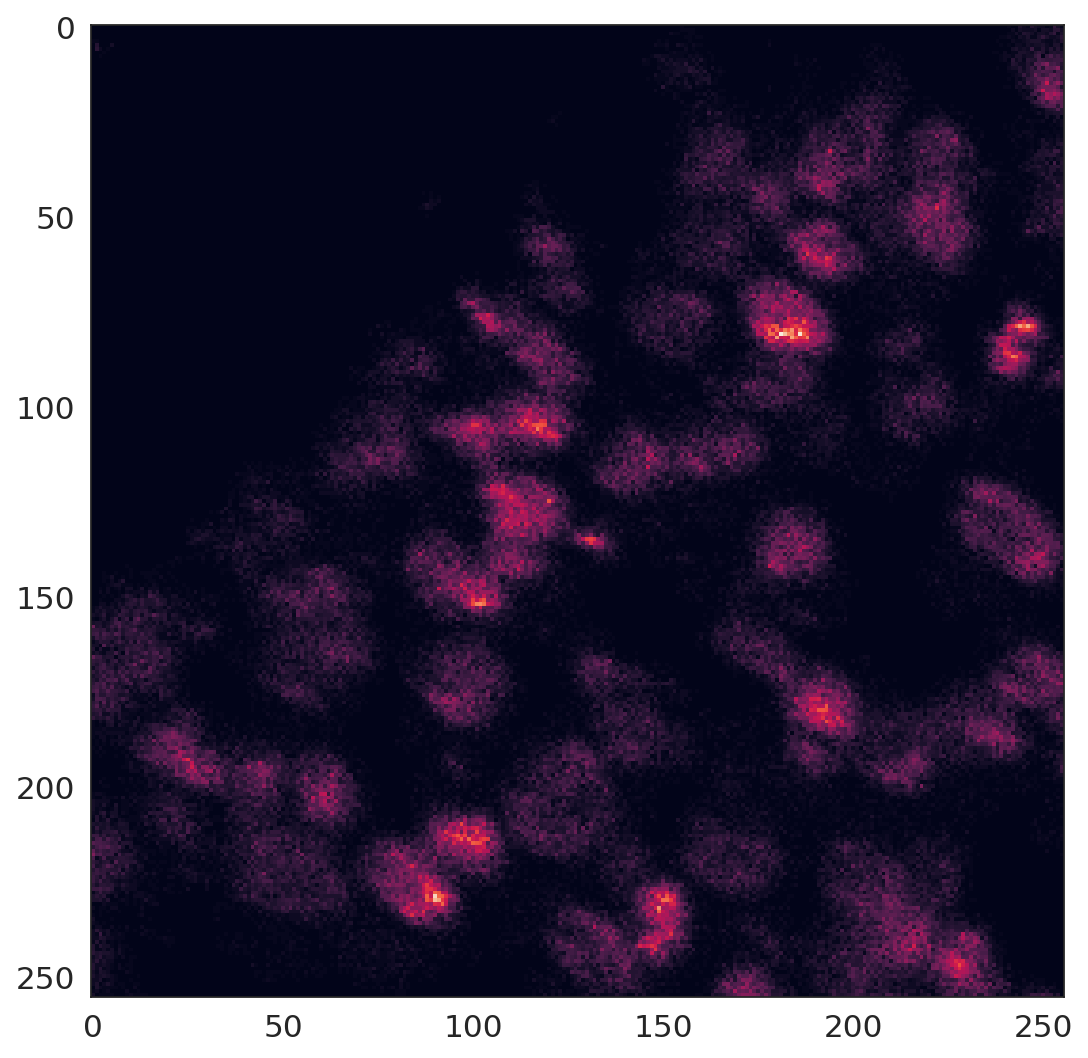

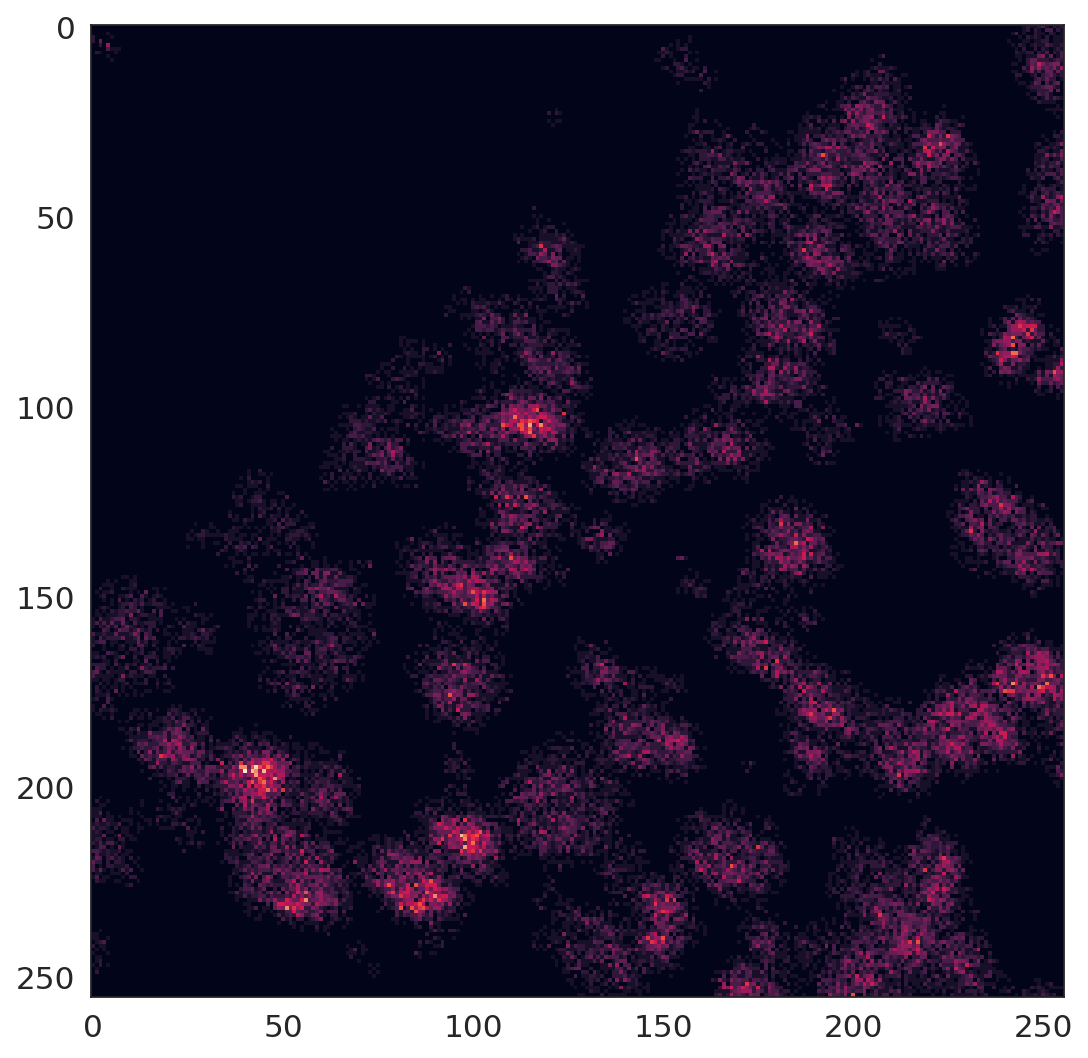

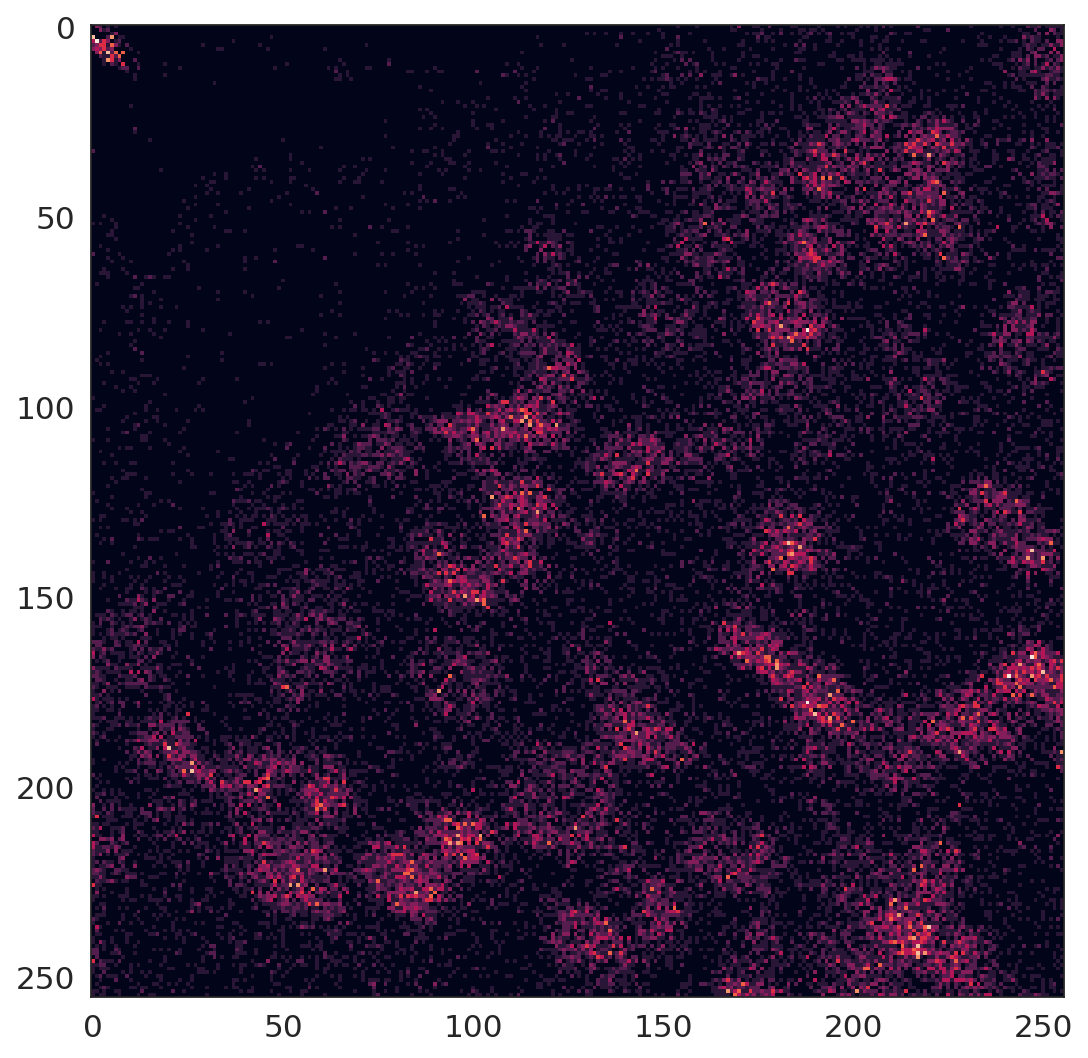

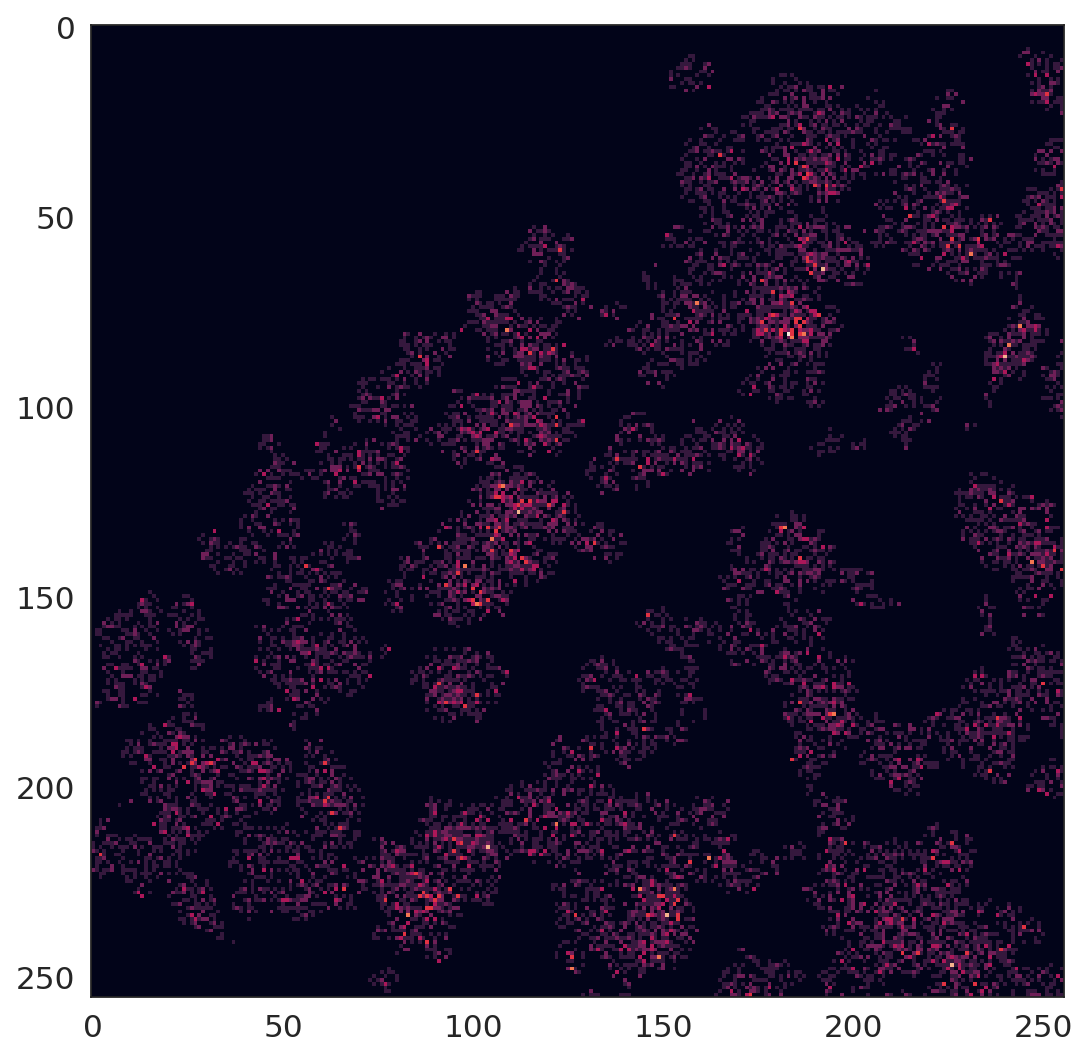

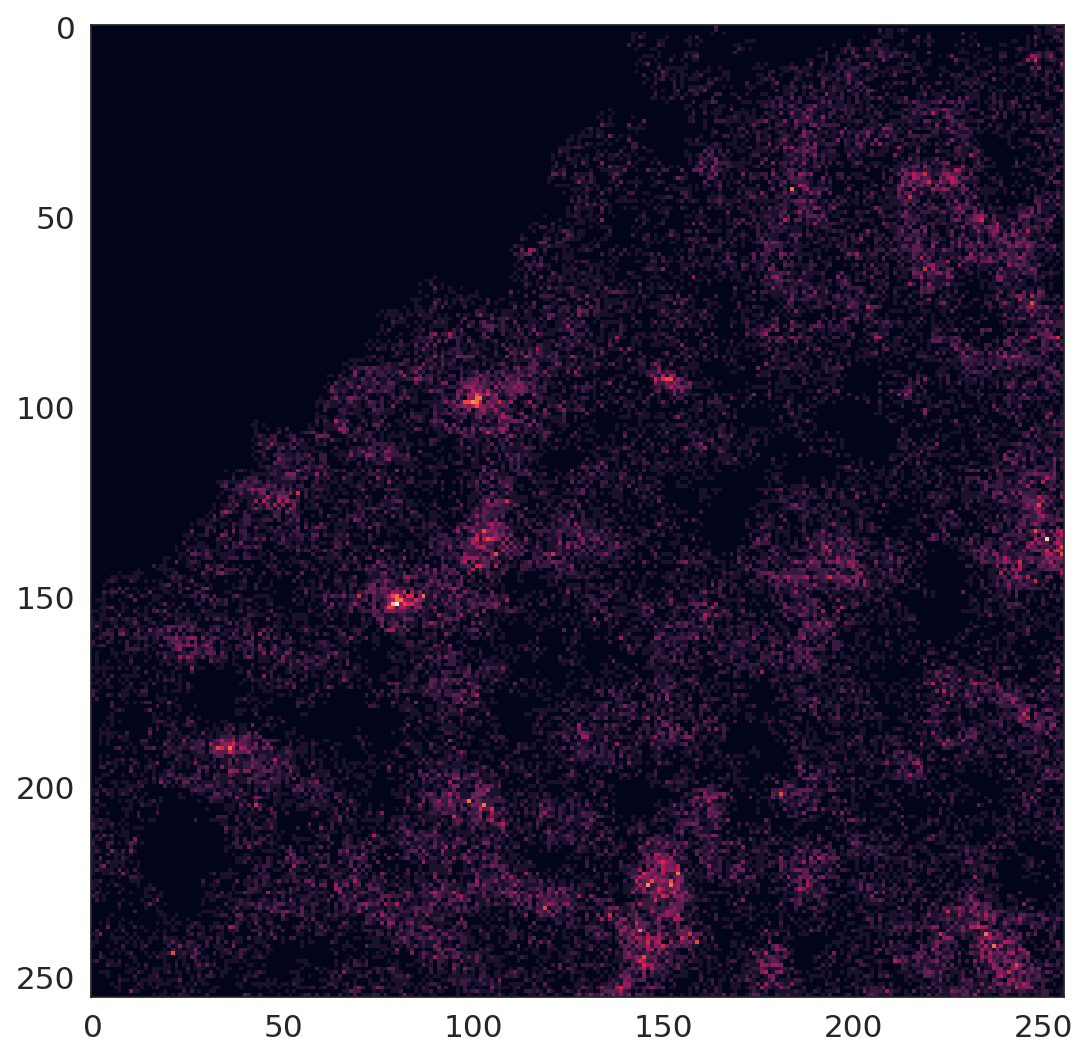

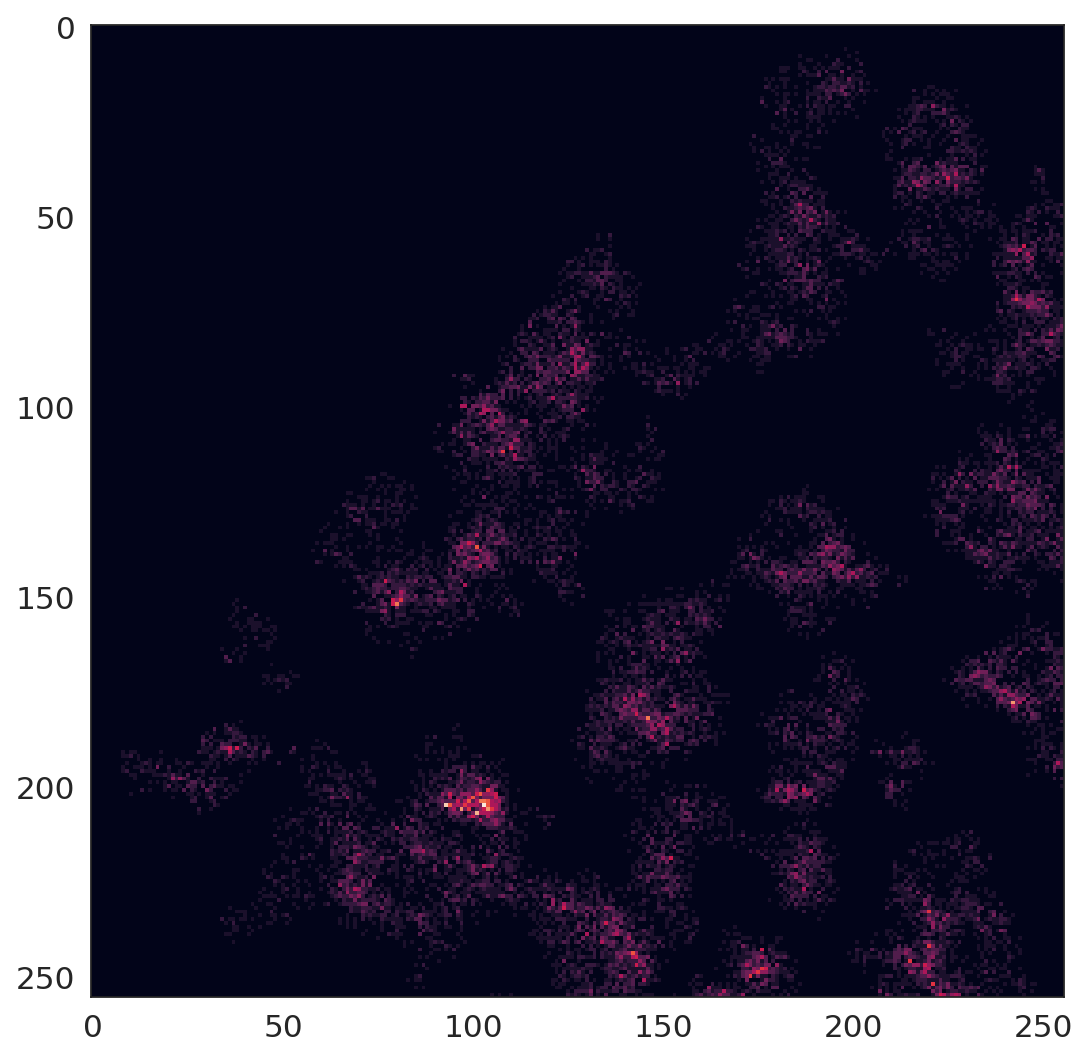

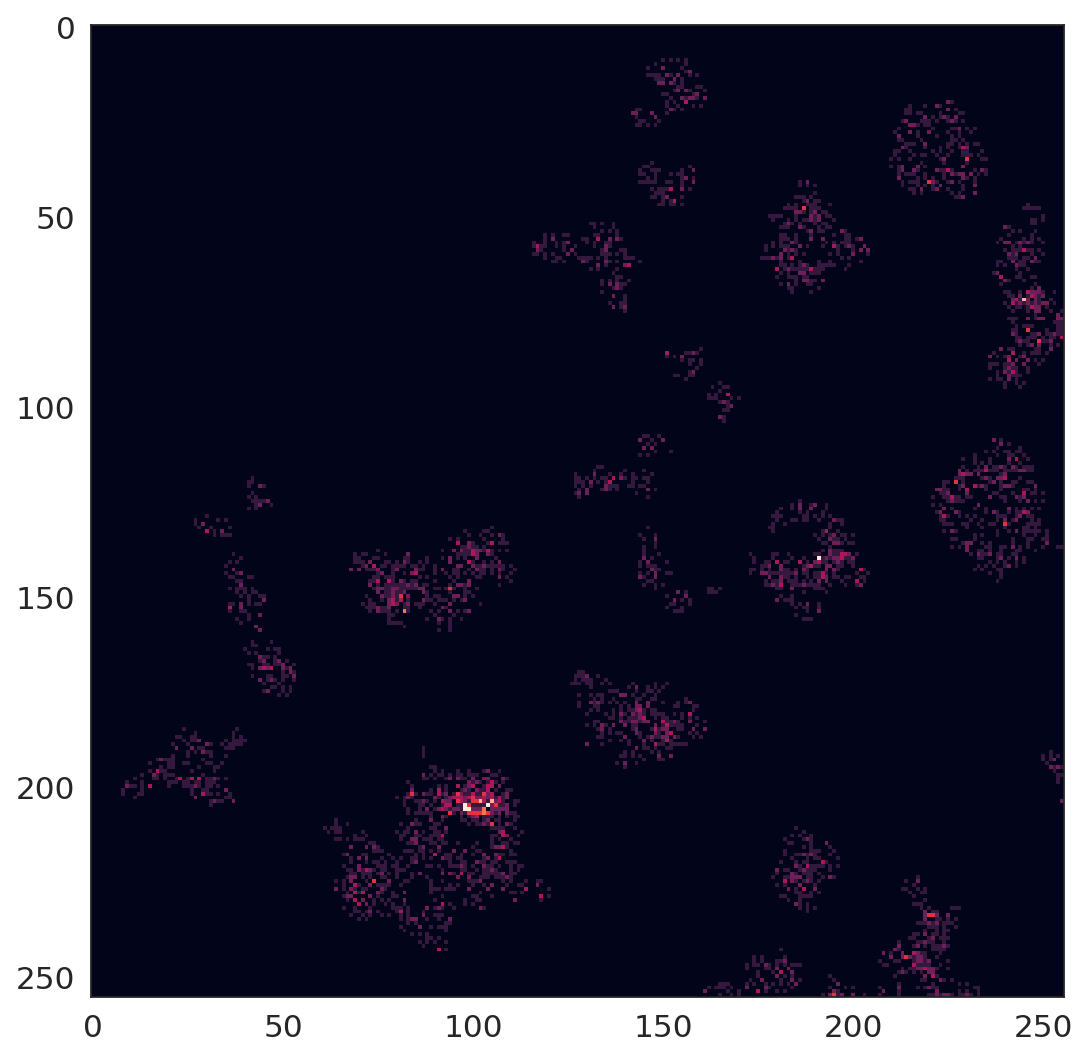

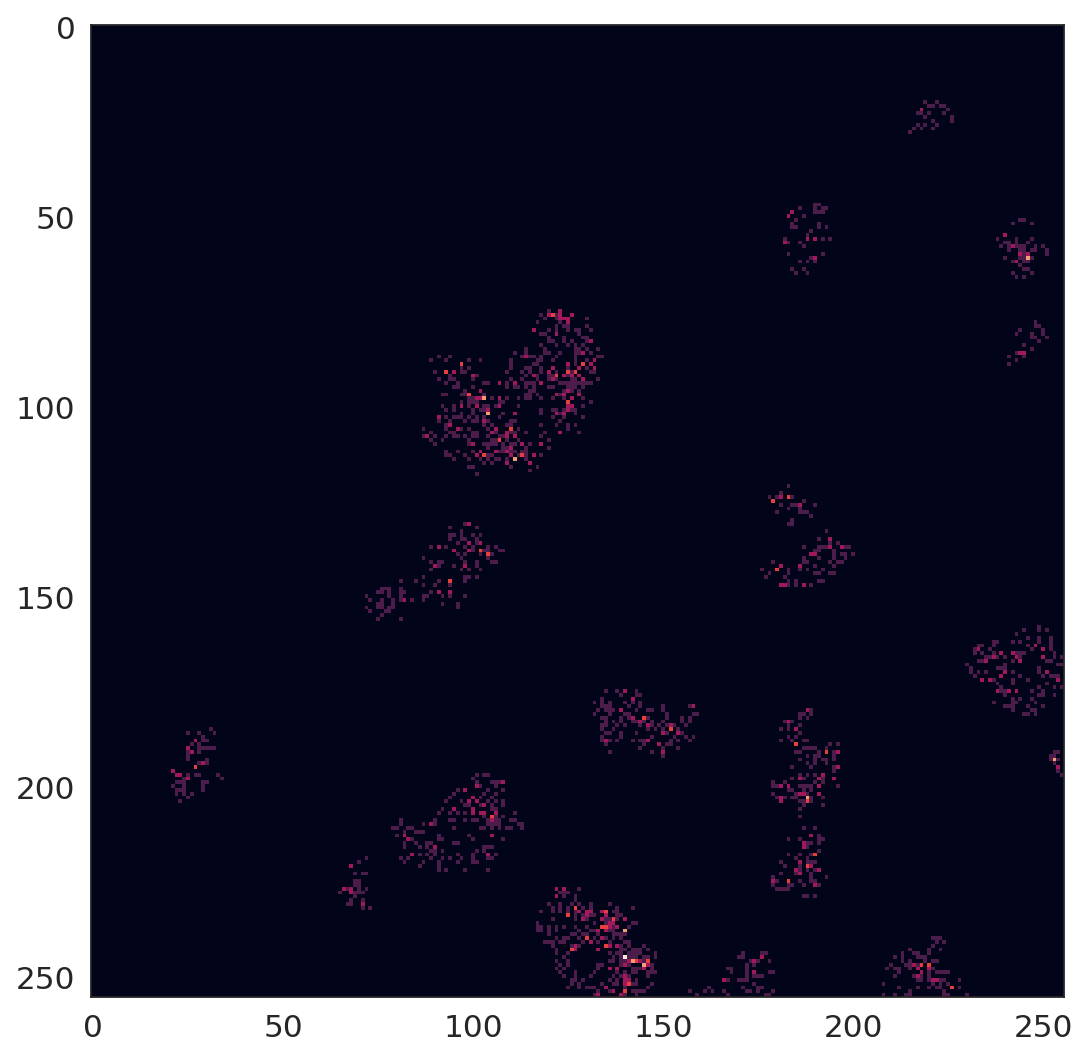

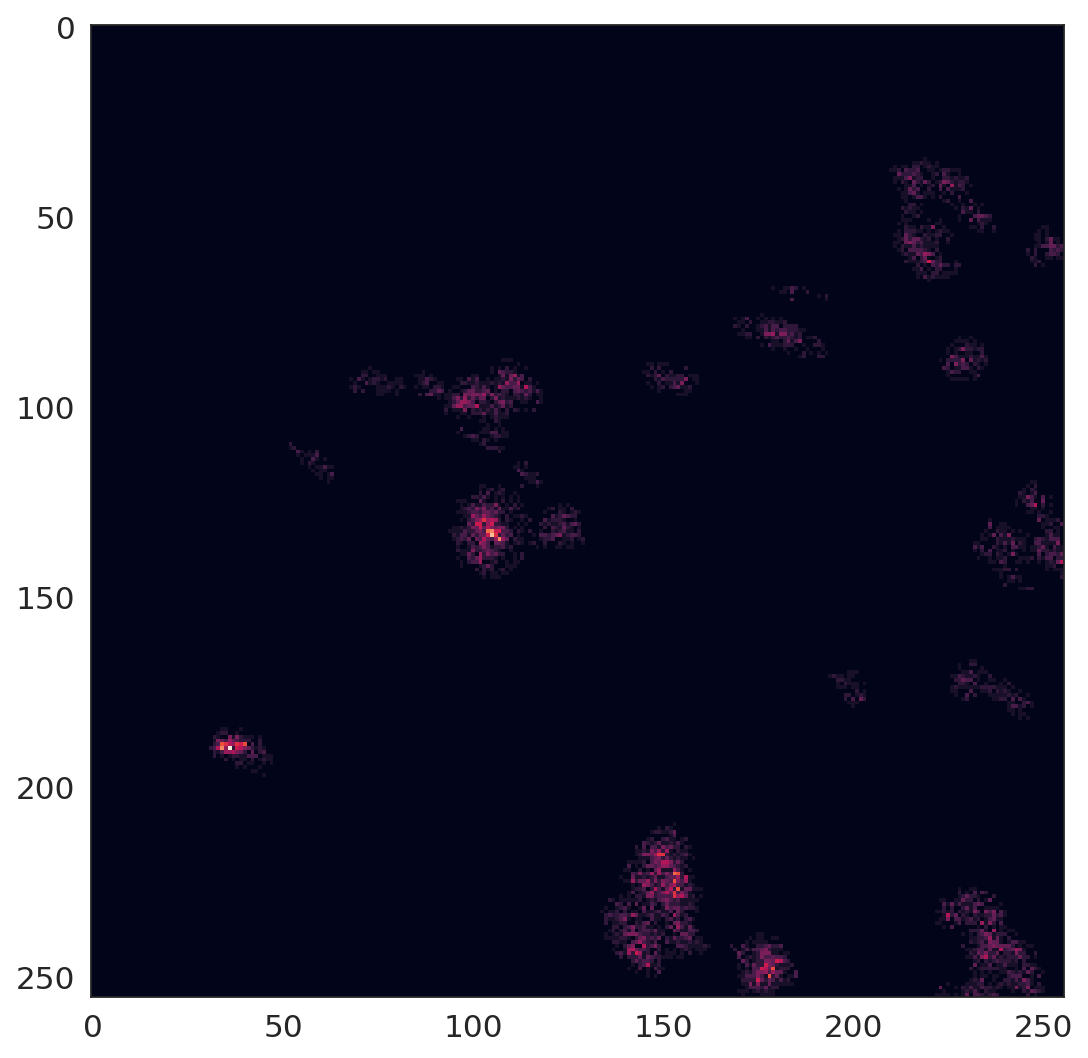

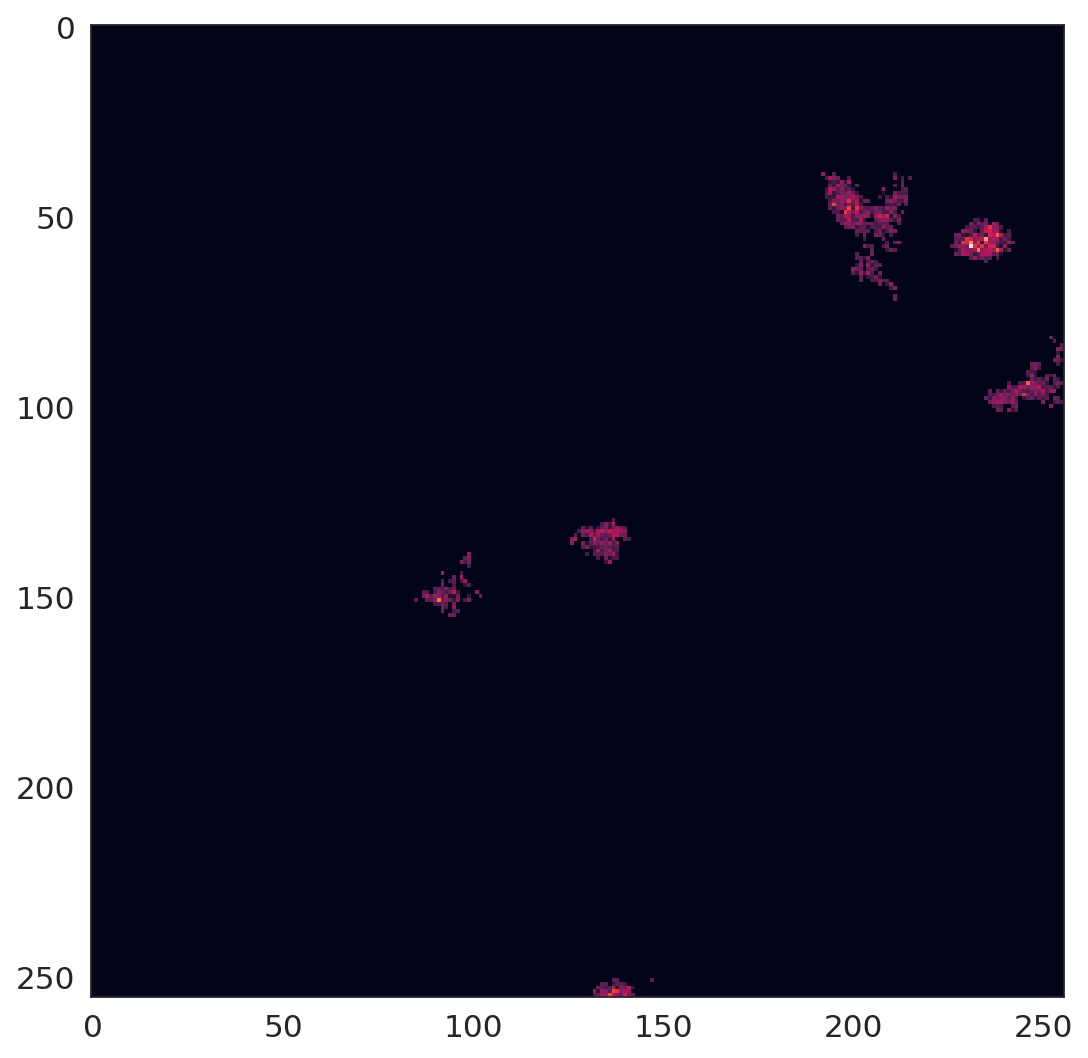

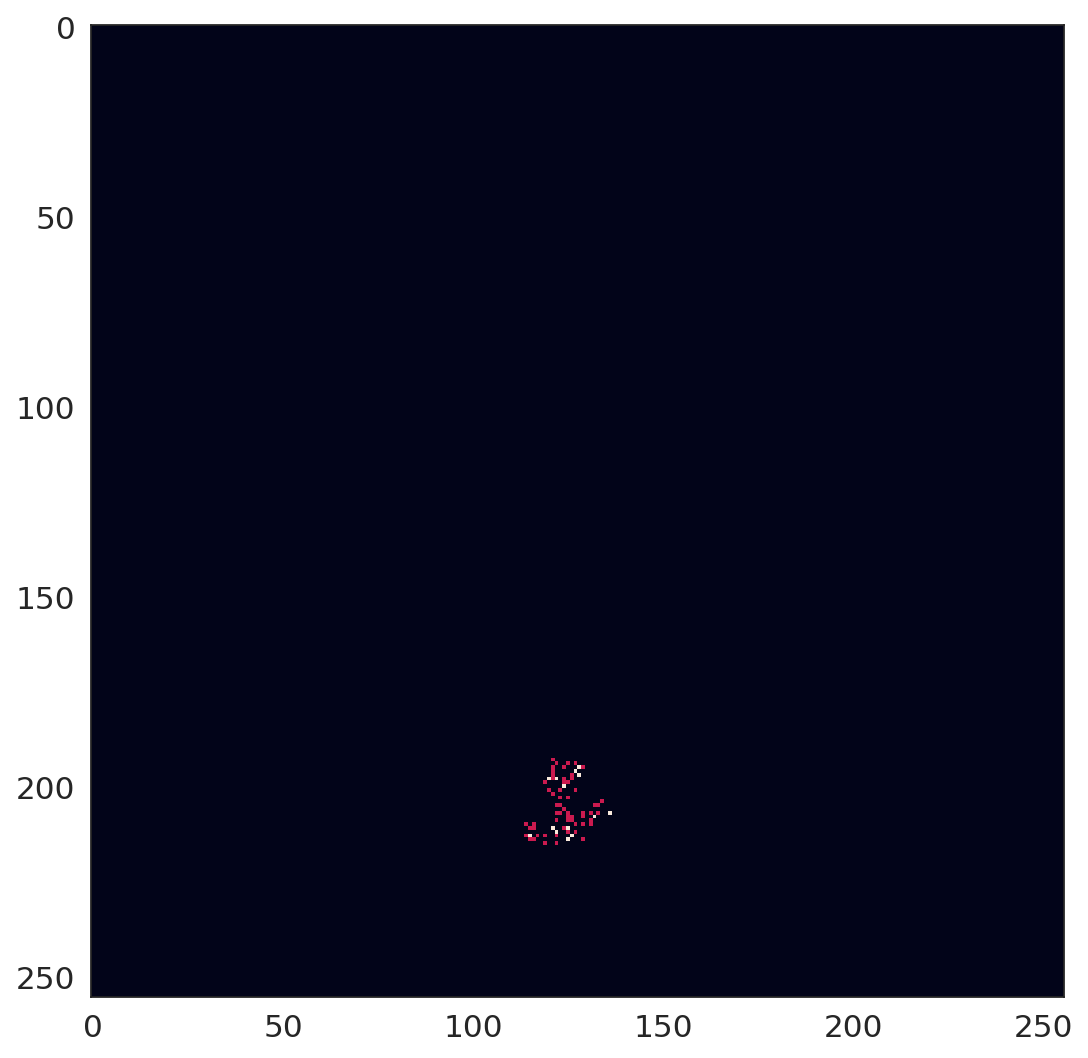

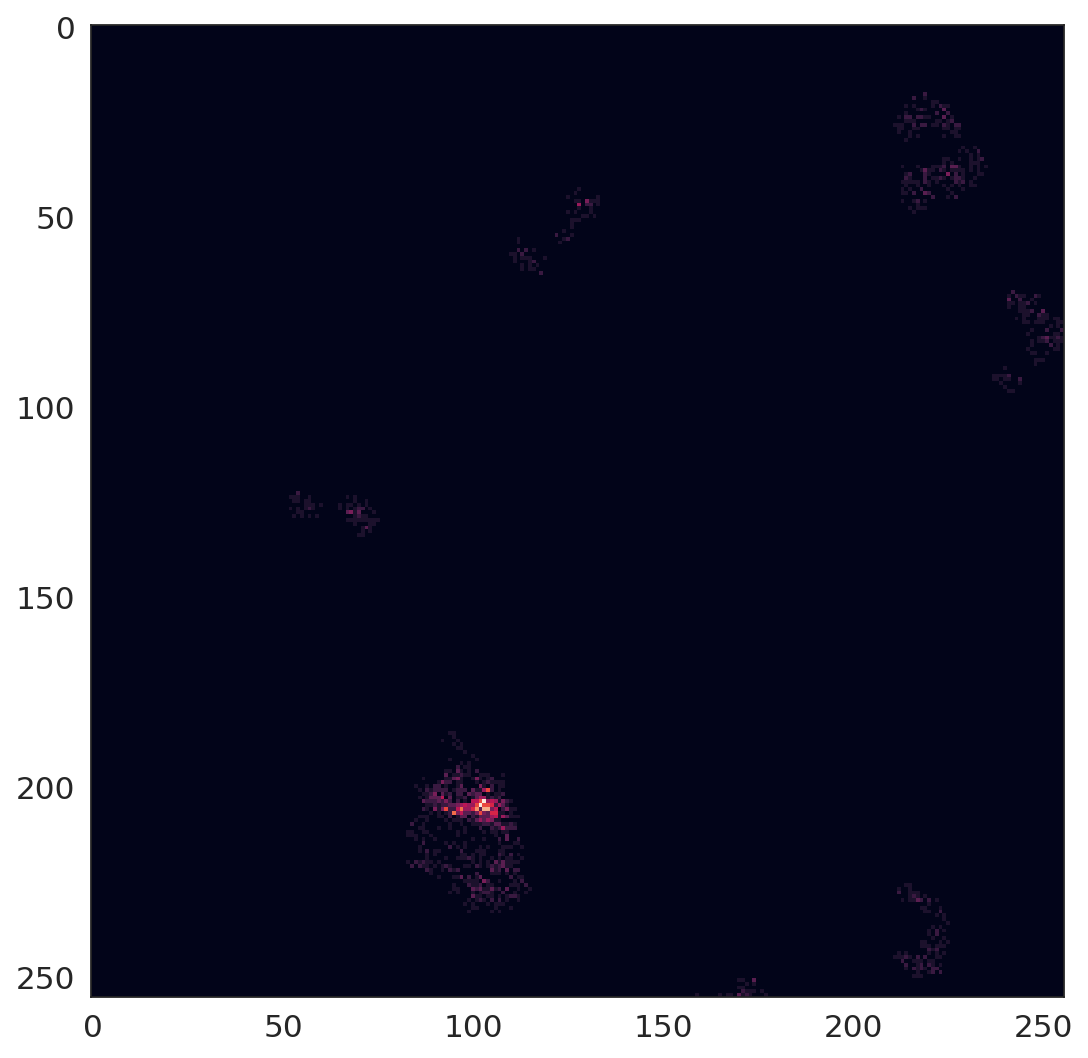

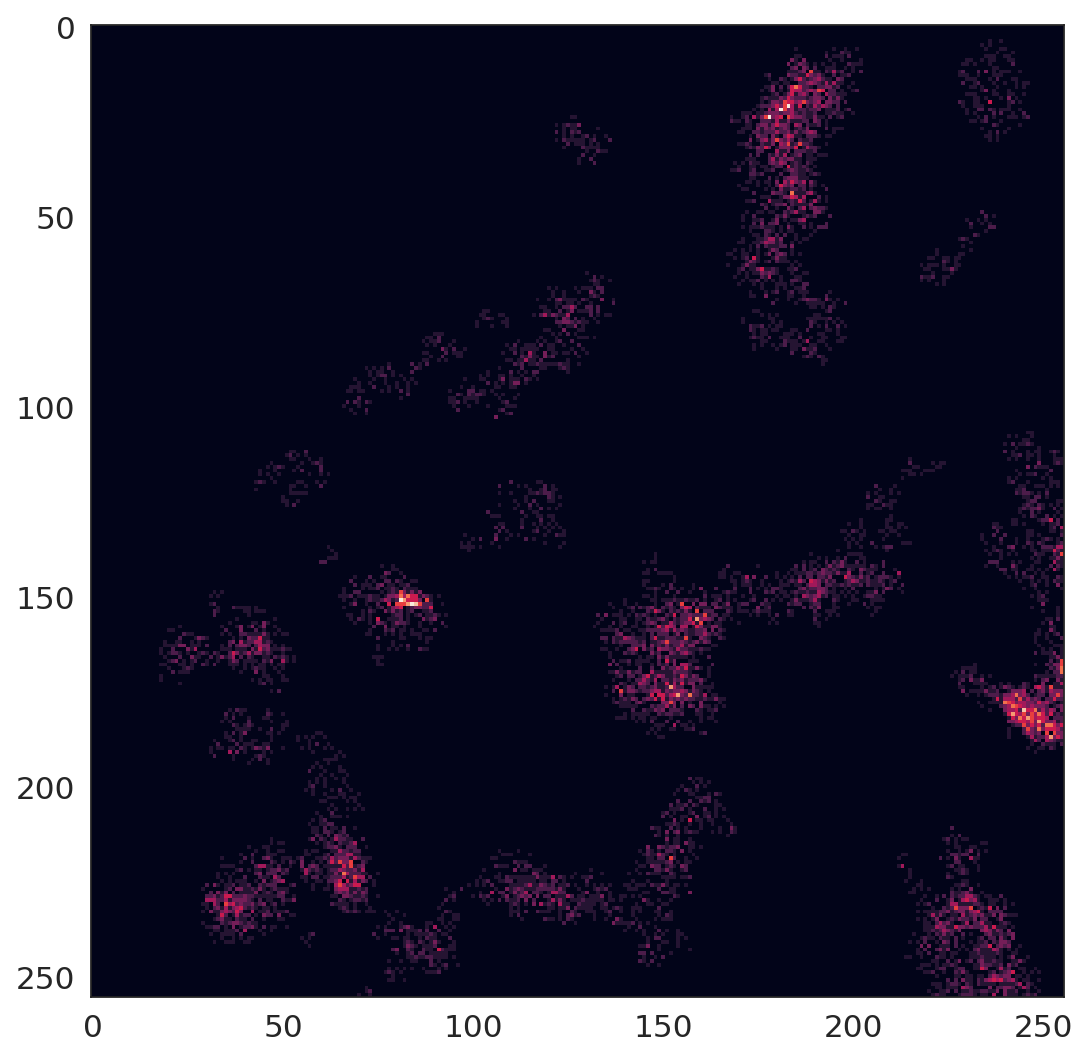

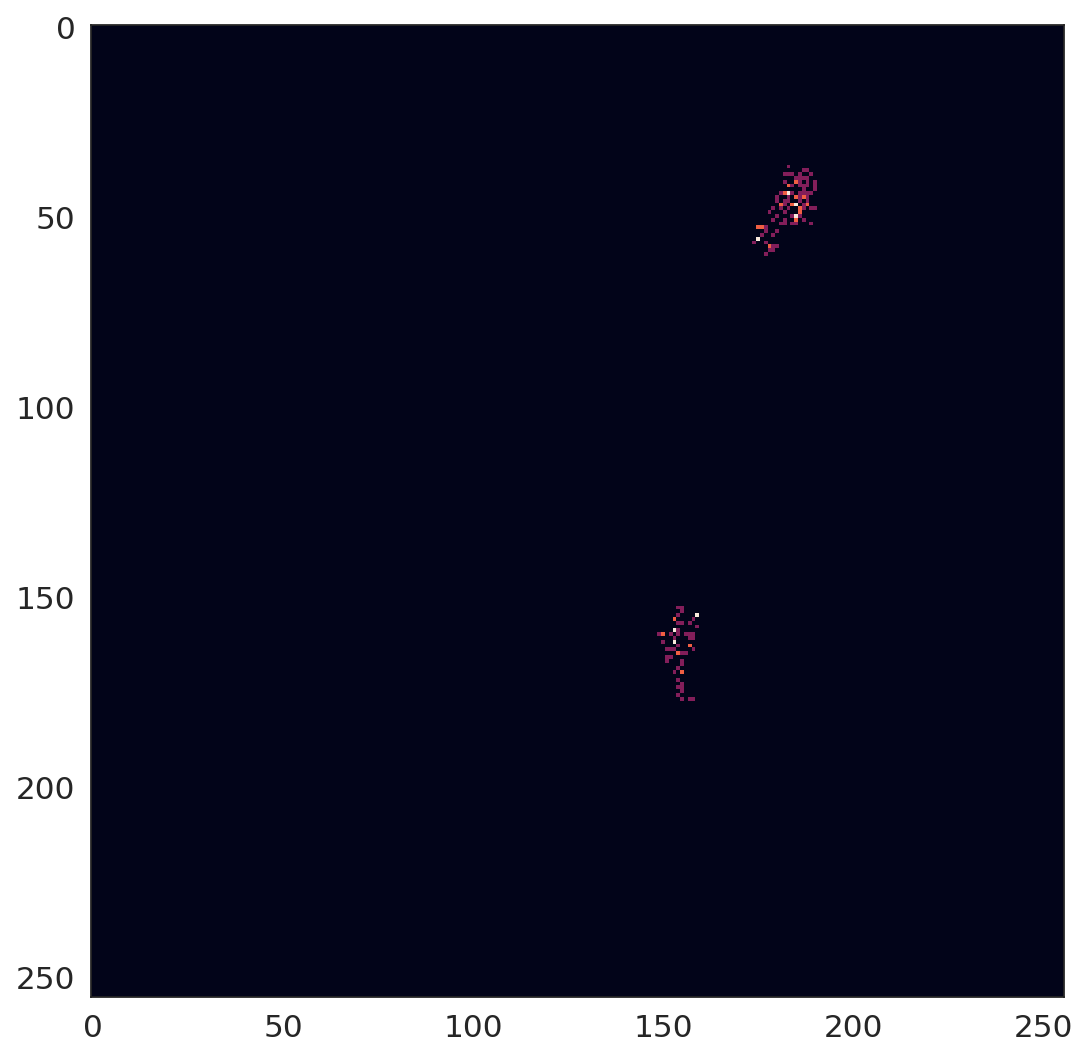

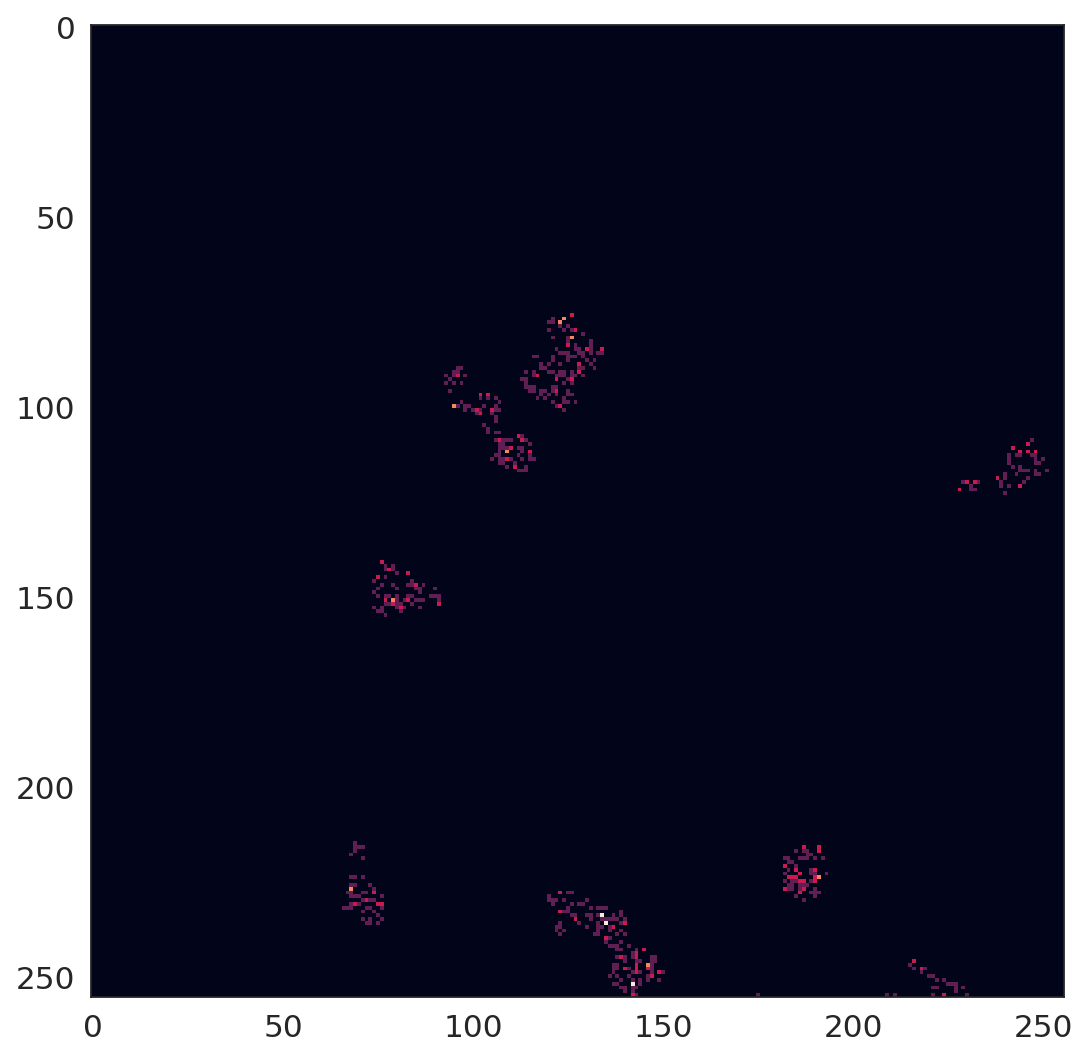

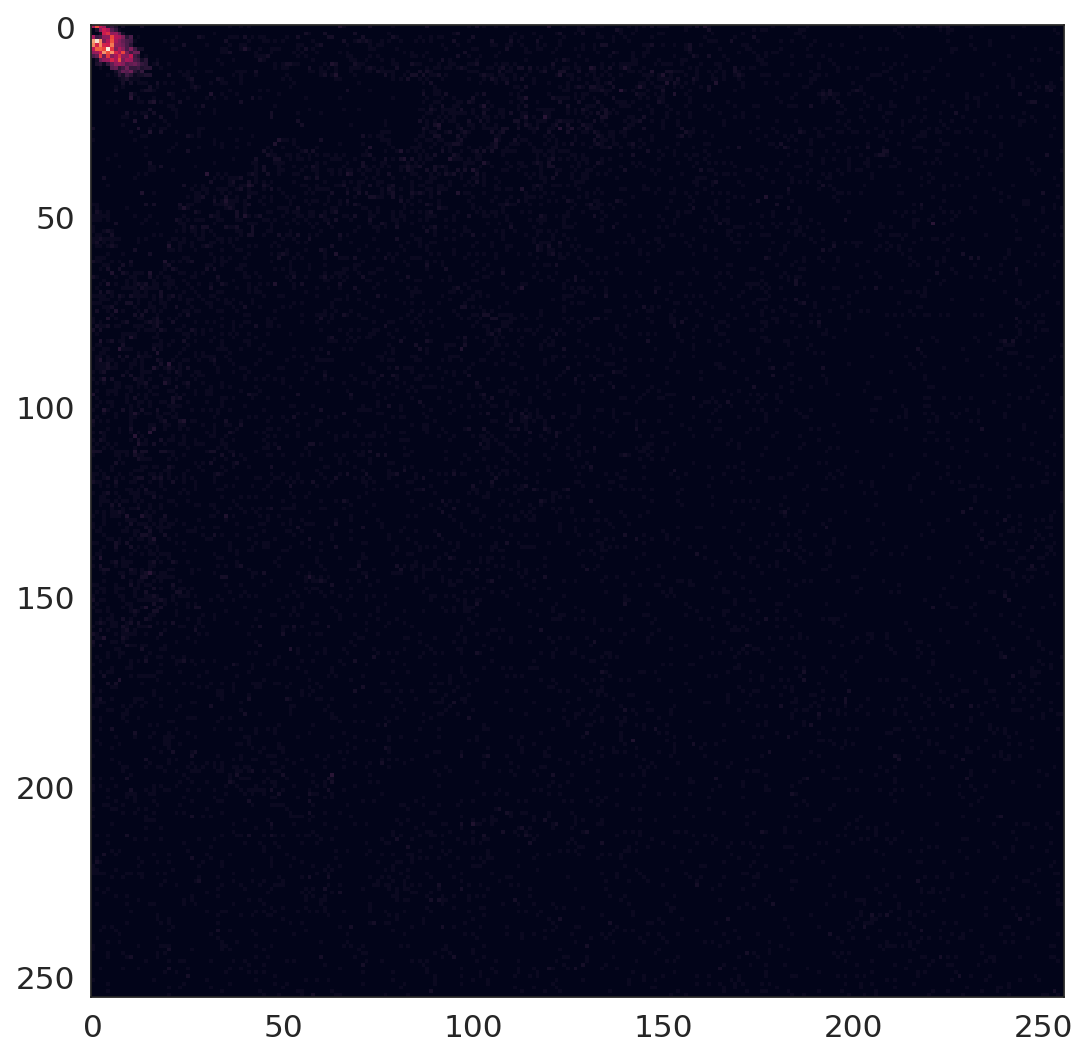

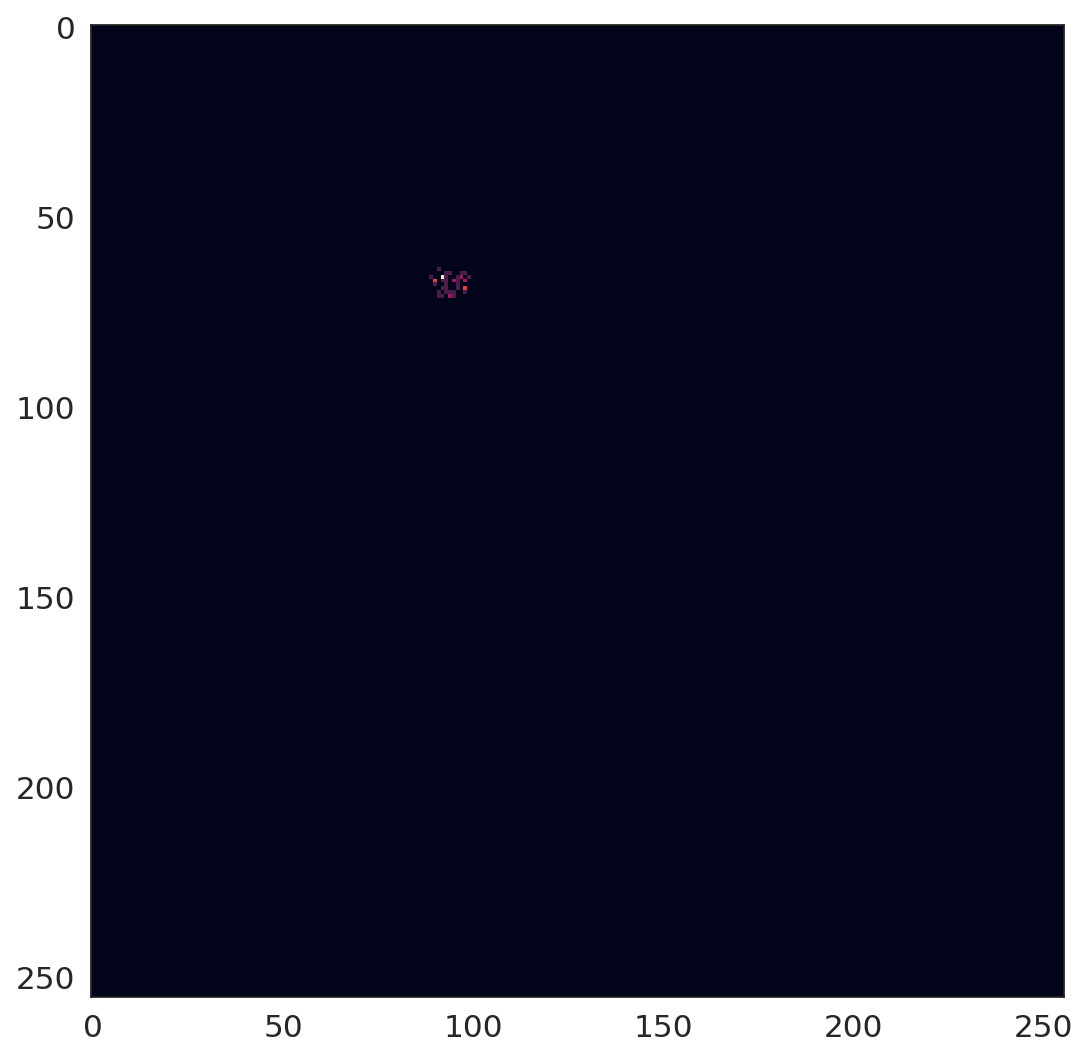

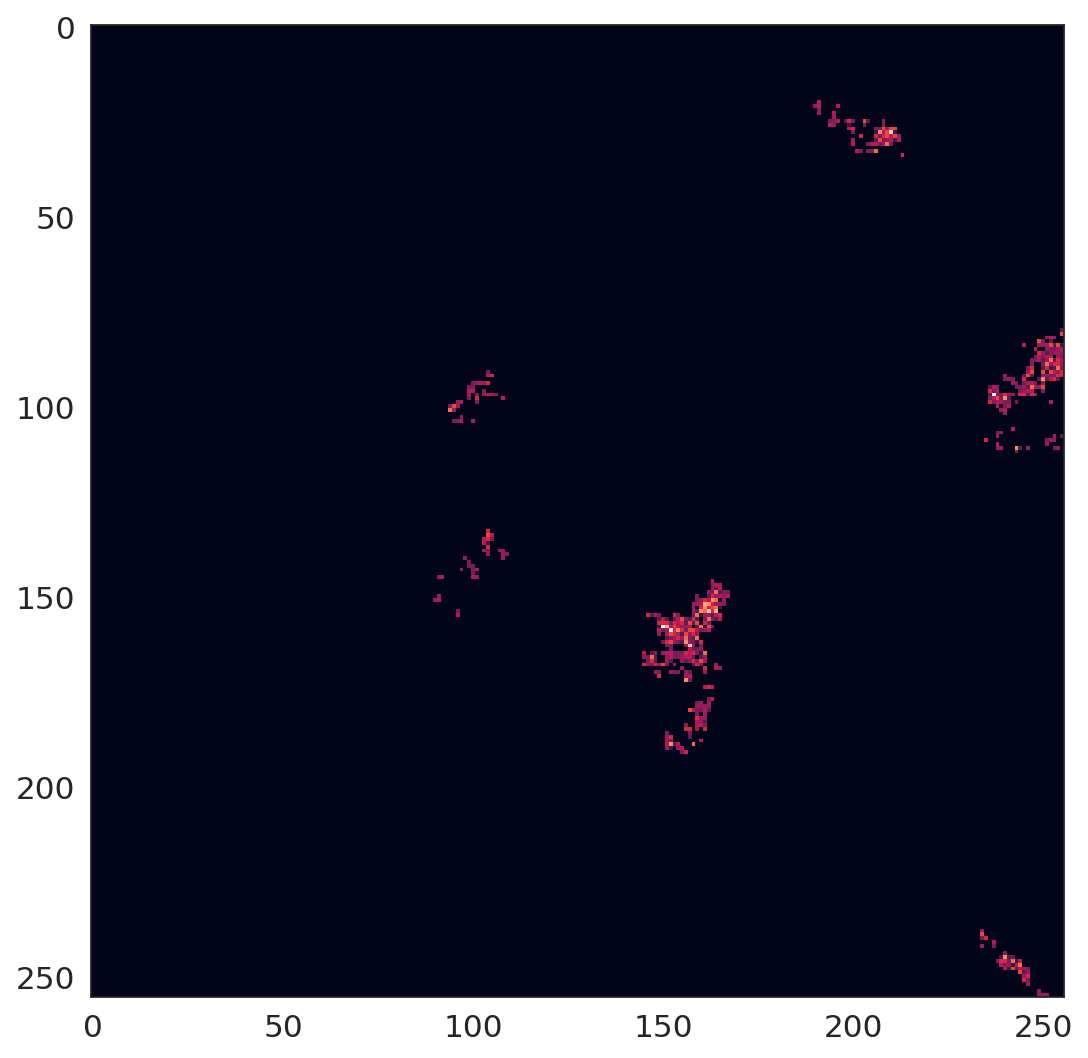

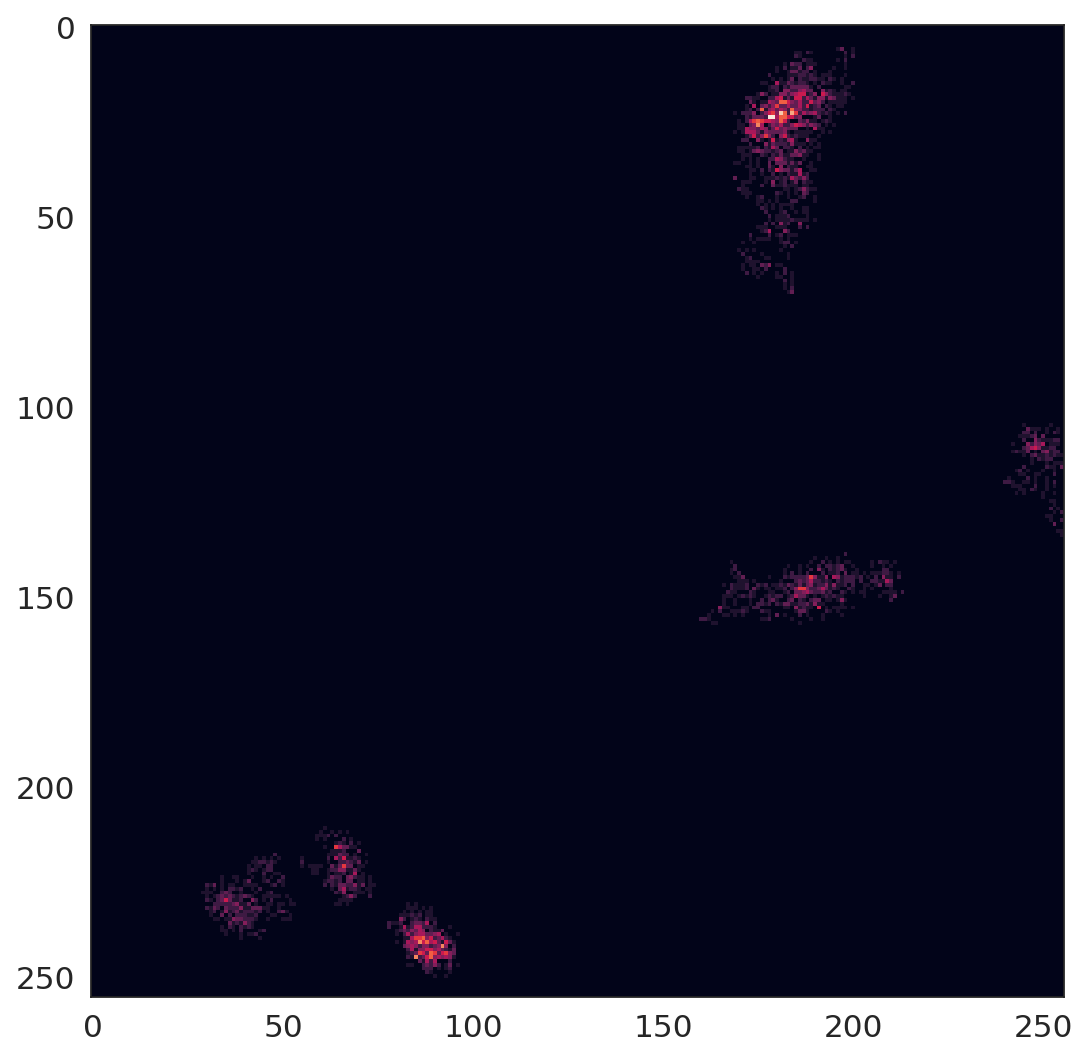

In [168]:
use_top = MIBI_nuclei_top
for i in range(use_top.shape[1]):
    plt.imshow(use_top[:,i].reshape(256,256))
    plt.show()

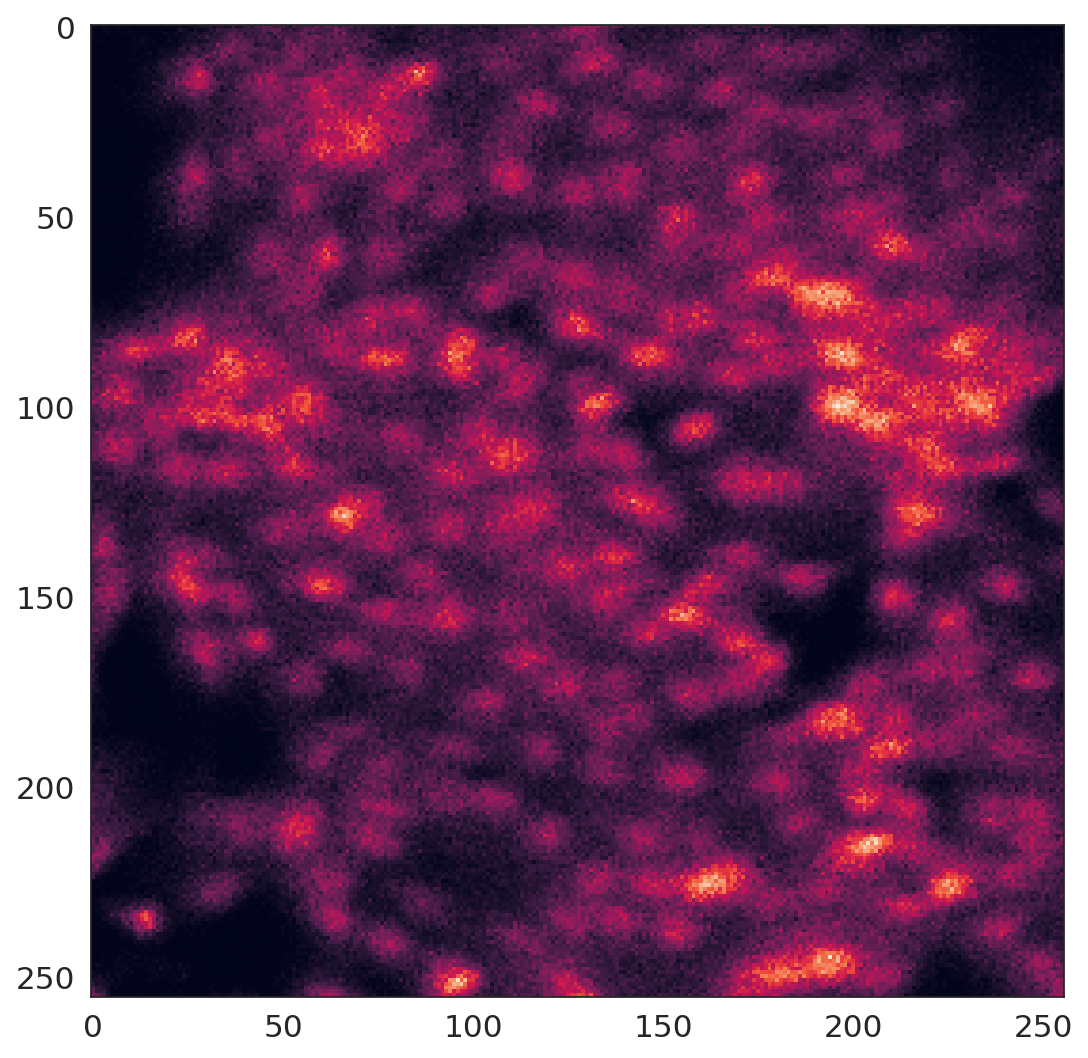

In [131]:
plt.imshow(SIMS_nuclei_top[:,0].reshape(256,256))

In [118]:
np.max(MIBI_nuclei_top[:,-1])

14

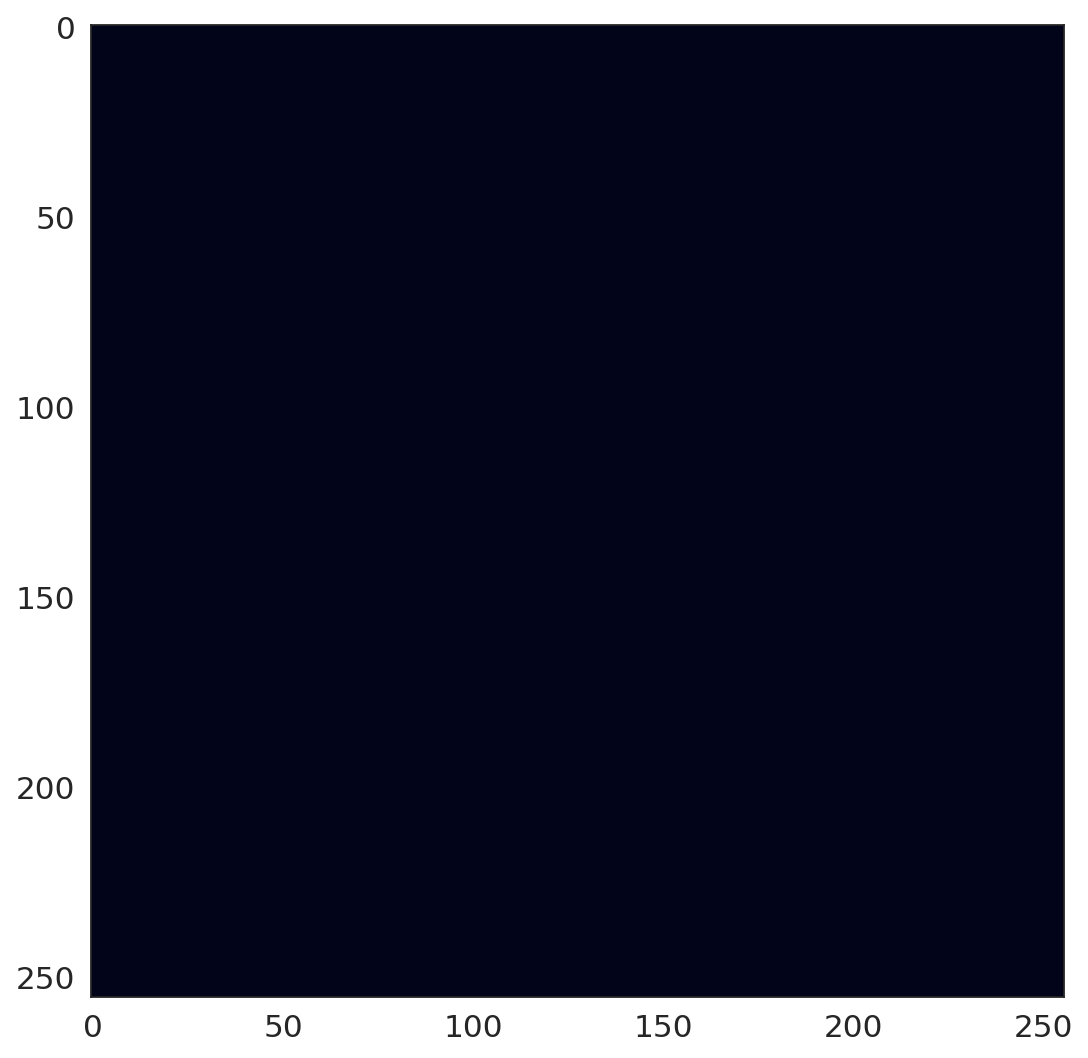

In [135]:
plt.imshow(MIBI_nuclei_top[:,2].reshape(256,256))